In [1]:
import os
import math
import json 
import time
import theano
import theano.tensor as T
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import pymc3 as pm
import matplotlib.pyplot as plt
from pymc3.distributions import Interpolated
from pymc3.distributions.discrete import Discrete, bound, draw_values, generate_samples
import pickle

In [2]:
path = "C:/Users/glius/Google Drive/HOPE/accelerometer/fitbit/"
obs_files = os.listdir(path)
obs_steps = {}
for i in range(24):
  obs_steps[str(i)]=[]
  
for filename in obs_files:
  if "2005" not in filename:
    data = pd.read_csv(path + filename)
    for i in range(data.shape[0]):
      t0 = data["ActivityMinute"][i]
      t1 = t0.split(" ")
      t2 = t1[0].split("/")
      t3 = t1[1].split(":")
      t4 = t1[2]
      if int(t3[0])==12 and t4=="AM":
        hour = 0
      elif int(t3[0])==12 and t4=="PM":
        hour = 12
      elif t4 == "PM":
        hour = int(t3[0])+12
      else:
        hour = int(t3[0])
      obs_steps[str(hour)].append(int(data["Steps"][i]))

In [3]:
steps = []
temp = []
for i in obs_steps.keys():
  steps.extend(obs_steps[i])
  temp.extend([int(i)]*len(obs_steps[i]))
steps = np.array(steps)
hours = np.zeros((len(temp),24))
for i in range(len(temp)):
  hours[i,temp[i]]=1

In [4]:
t_steps = theano.shared(steps)
t_hours = theano.shared(hours)
map_tensor_batch = {t_steps: pm.Minibatch(steps, batch_size = 2048), 
                    t_hours: pm.Minibatch(hours, batch_size = 2048)}

C:\Users\glius\anaconda3\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
C:\Users\glius\anaconda3\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [5]:
with pm.Model() as model:
  psis = pm.Uniform("psi",0.001,0.999,shape=24)
  alphas = pm.Gamma("alpha",16,4,shape=24)
  mus = pm.Gamma("mu",50,2,shape=24)
  psi = T.dot(t_hours,psis)
  alpha = T.dot(t_hours,alphas)
  mu = T.dot(t_hours,mus)
  obs = pm.ZeroInflatedNegativeBinomial("obs",psi=psi,alpha=alpha,mu=mu,observed=t_steps)
with model:
  approx = pm.fit(method=pm.ADVI(),n=2000,obj_optimizer=pm.adagrad(learning_rate=1e-1),more_replacements=map_tensor_batch)
advi_trace = approx.sample(10000)

Finished [100%]: Average Loss = 1,975.6


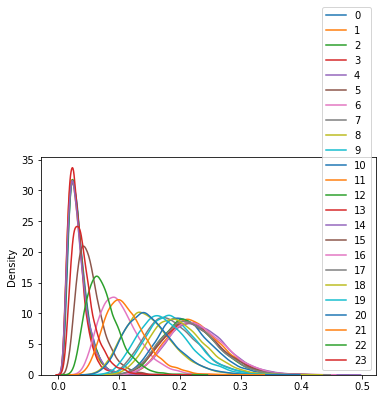

In [6]:
for i in range(24):
  sns.kdeplot(advi_trace["psi"][:,i],label=i)
plt.legend()

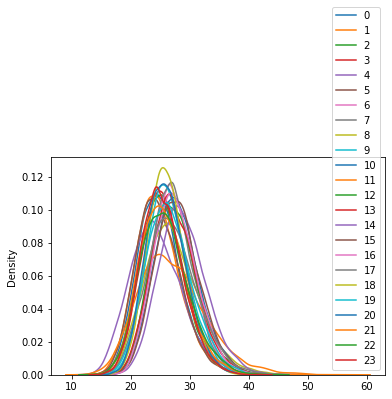

In [7]:
for i in range(24):
  sns.kdeplot(advi_trace["mu"][:,i],label=i)
plt.legend()

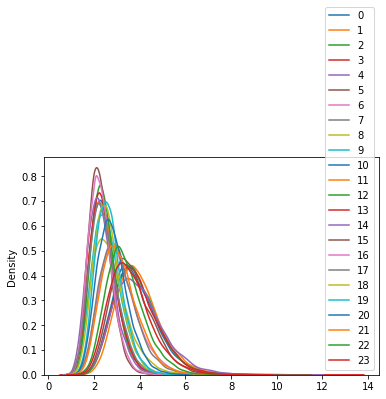

In [8]:
for i in range(24):
  sns.kdeplot(advi_trace["alpha"][:,i],label=i)
plt.legend()

In [9]:
def from_posterior(samples):
  new_mean = np.zeros(samples.shape[1]) 
  new_var = np.zeros(samples.shape[1])
  for j in range(24):
    new_mean[j] = np.mean(samples[:,j])
    new_var[j] = np.var(samples[:,j])
  return [new_mean,np.diag(new_var)]

In [10]:
def update_post(steps,hours,prior_dict):
  temp = np.zeros((len(steps),24))
  for i in range(len(steps)):
    temp[i,hours[i]]=1
  t_steps = theano.shared(steps)
  t_hours = theano.shared(temp)
  map_tensor_batch = {t_steps: pm.Minibatch(steps,2048),
                      t_hours: pm.Minibatch(temp,2048)}
  mean_var = {}
  for i in prior_dict.keys():
    mean_var[i] = from_posterior(prior_dict[i])

  with pm.Model() as model:
    psis = pm.MvNormal("psi",mu = mean_var["psi"][0],cov = mean_var["psi"][1],shape=24)
    alphas = pm.MvNormal("alpha",mu = mean_var["alpha"][0],cov = mean_var["alpha"][1],shape=24)
    mus = pm.MvNormal("mu",mu = mean_var["mu"][0],cov = mean_var["mu"][1],shape=24)
    psi = T.dot(t_hours,T.exp(psis))
    alpha = T.dot(t_hours,T.exp(alphas))
    mu = T.dot(t_hours,mus)
    obs = pm.ZeroInflatedNegativeBinomial("obs",psi=psi,alpha=alpha,mu=mu,observed=t_steps)
  with model:
    approx = pm.fit(method=pm.ADVI(),n=2000,obj_optimizer=pm.adagrad(learning_rate=1e-1),more_replacements=map_tensor_batch)
  advi_trace = approx.sample(10000)
  prior_dict = {"psi":advi_trace["psi"],"alpha":advi_trace["alpha"],"mu":advi_trace["mu"]}
  post_pred = {}
  for i in range(24):
    post_pred[i] = pm.ZeroInflatedNegativeBinomial.dist(psi=np.exp(prior_dict["psi"][:,i]),
                  alpha=np.exp(prior_dict["alpha"][:,i]),mu=prior_dict["mu"][:,i]).random(size=1)[0]
  return post_pred, prior_dict

In [11]:
data = pd.read_csv("C:/Users/glius/Google Drive/HOPE/accelerometer/fitbit/2005_minuteStepsNarrow.csv")
observed_steps = {}
observed_hours = {}
i = 0
while i < data.shape[0]:
  t0 = data["ActivityMinute"][i]
  t1 = t0.split(" ")
  t2 = t1[0].split("/")
  t3 = t1[1].split(":")
  t4 = t1[2]
  year = int(t2[2])
  month = int(t2[0])
  day = int(t2[1])
  if int(t3[0])==12 and t4=="AM":
    hour = 0
  elif int(t3[0])==12 and t4=="PM":
    hour = 12
  elif t4 == "PM":
    hour = int(t3[0])+12
  else:
    hour = int(t3[0])
  if (year,month,day) not in observed_steps.keys():
    observed_steps[(year,month,day)] = [int(data["Steps"][i])]
    observed_hours[(year,month,day)] = [hour]
  else:
    observed_steps[(year,month,day)].append(int(data["Steps"][i]))
    observed_hours[(year,month,day)].append(hour)
  i = i + np.random.choice([1,2,3])

In [12]:
prior_dict = {"psi":np.log(advi_trace["psi"]),"alpha":np.log(advi_trace["alpha"]),"mu":advi_trace["mu"]}
all_priors = [prior_dict]
counter = 0
for d in observed_steps.keys():
  if counter<5:
    print(d) 
    steps = np.array(observed_steps[d])
    hours = np.array(observed_hours[d])
    post_pred, prior_dict = update_post(steps,hours,prior_dict)
    all_priors.append(prior_dict)
    counter = counter + 1
  else:
    break

(2018, 1, 19)


C:\Users\glius\anaconda3\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


Finished [100%]: Average Loss = 1,949


(2018, 1, 20)


C:\Users\glius\anaconda3\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


Finished [100%]: Average Loss = 1,936.5


(2018, 1, 21)


Finished [100%]: Average Loss = 1,172.9


(2018, 1, 22)


Finished [100%]: Average Loss = 1,652.7


(2018, 1, 23)


Finished [100%]: Average Loss = 1,514.4


0
1
2
3
4
5


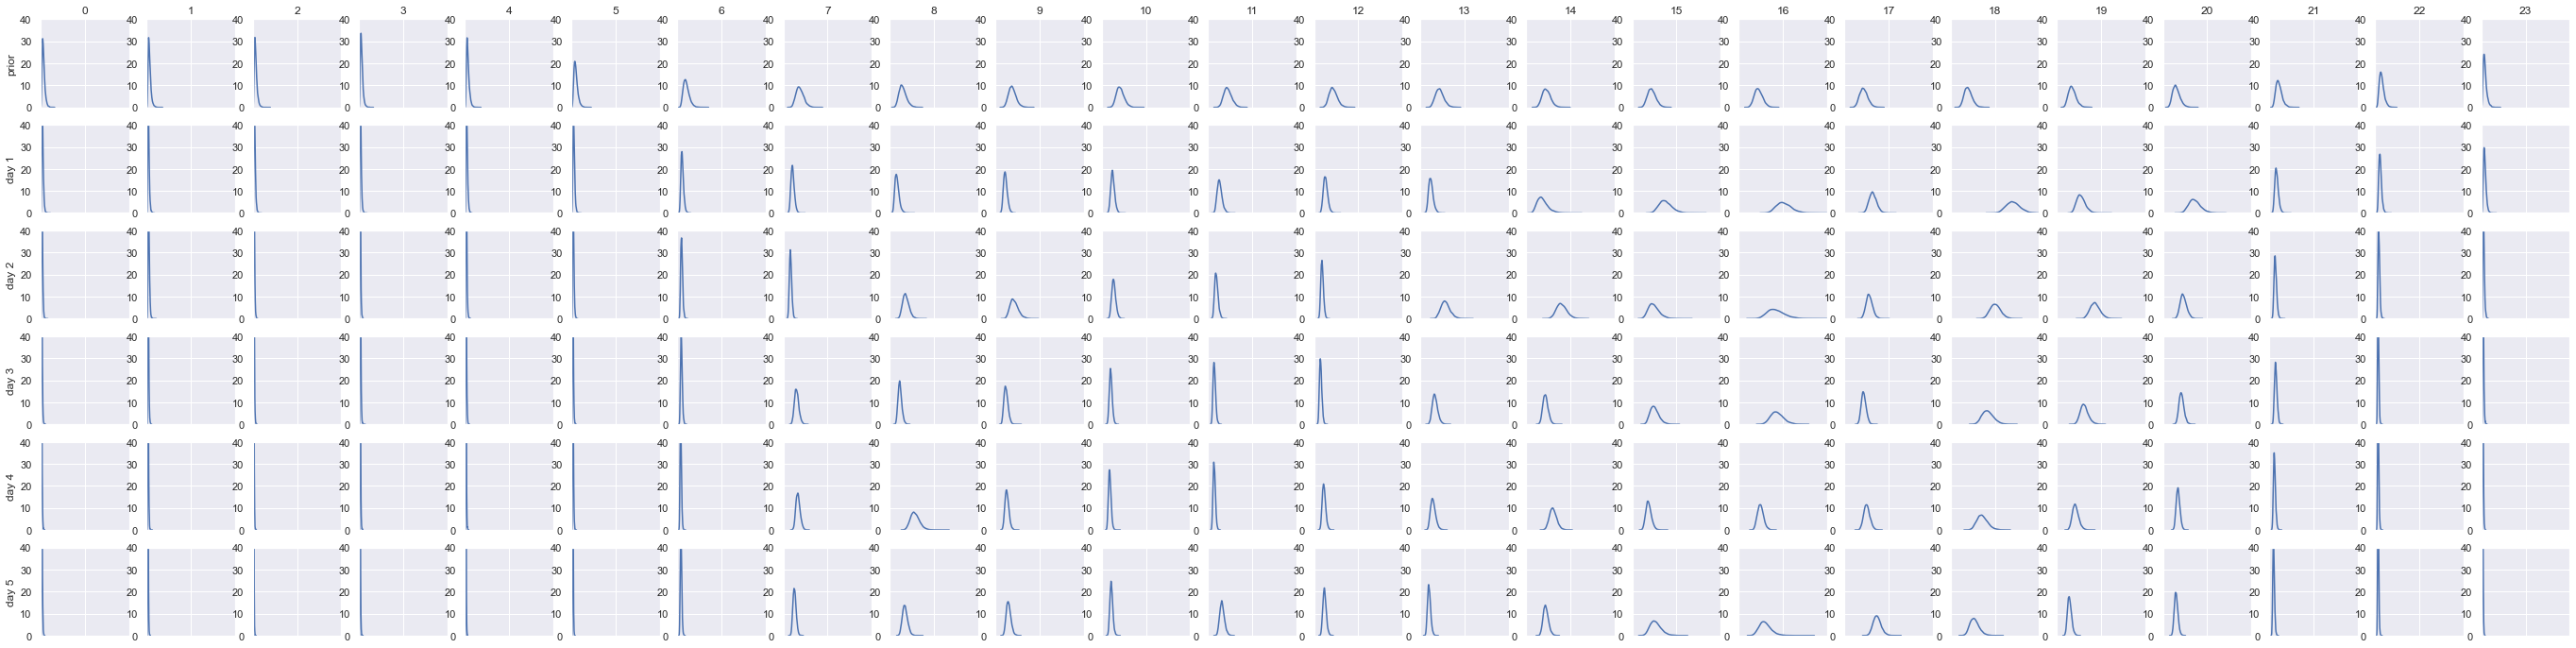

In [13]:
var_name = "psi"
sns.set(rc={'figure.figsize':(2*24,2*6)})
for i in range(6):
  print(i)
  temp = all_priors[i]
  for j in range(24):
    plt.subplot(6, 24, 24*i+j+1)
    plt.xlim(0, 1)
    plt.ylim(0, 40)
    g = sns.kdeplot(np.exp(temp[var_name][:,j]))
    if j==0:
      if i >0:
        g.set(ylabel="day " + str(i))
      else:
        g.set(ylabel="prior")
    else:
      g.set(ylabel=None)
    if i ==0:
      g.set_title(str(j))
    g.set(xlabel=None)
    g.set(xticklabels=[])
  
plt.savefig('psi.pdf')  

In [14]:
def post_summary(post_pred,steps,hours,sig_lvl):
  summary = {}
  cumsum = np.zeros(1000)
  for i in range(24):
    temp = steps[hours==i]
    M = 60-len(temp)
    s_list = []
    for j in range(1000):
      h = np.random.choice(post_pred[i],M)
      s_list.append(sum(h))
    s_list = np.array(s_list)
    hourly_sum_sample = s_list + sum(temp)
    cumsum = cumsum + hourly_sum_sample
    m = int(np.mean(hourly_sum_sample))
    CI = np.percentile(hourly_sum_sample,[(sig_lvl/2)*100,(1-sig_lvl/2)*100])
    summary[i] = [m,int(CI[0]),int(CI[1])]
  m = int(np.mean(cumsum))
  CI = np.percentile(cumsum,[(sig_lvl/2)*100,(1-sig_lvl/2)*100])
  summary["daily"] = [m,int(CI[0]),int(CI[1])]
  return summary

In [15]:
sig_lvl = 0.05
prior_dict = {"psi":np.log(advi_trace["psi"]),"alpha":np.log(advi_trace["alpha"]),"mu":advi_trace["mu"]}
all_summary = []
counter = 0
for d in observed_steps.keys():
  if counter<42:
    print(d) 
    steps = np.array(observed_steps[d])
    hours = np.array(observed_hours[d])
    post_pred, prior_dict = update_post(steps,hours,prior_dict)
    all_summary.append(post_summary(post_pred,steps,hours,sig_lvl))
    counter = counter + 1
  else:
    break

(2018, 1, 19)


C:\Users\glius\anaconda3\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


Finished [100%]: Average Loss = 1,950.7


(2018, 1, 20)


Finished [100%]: Average Loss = 1,942.7


(2018, 1, 21)


Finished [100%]: Average Loss = 1,162.4


(2018, 1, 22)


Finished [100%]: Average Loss = 1,659.4


(2018, 1, 23)


Finished [100%]: Average Loss = 1,512.4


(2018, 1, 24)


Finished [100%]: Average Loss = 1,339.2


(2018, 1, 25)


Finished [100%]: Average Loss = 1,625.5


(2018, 1, 26)


Finished [100%]: Average Loss = 2,123.9


(2018, 1, 27)


Finished [100%]: Average Loss = 2,708.8


(2018, 1, 28)


Finished [100%]: Average Loss = 2,445.6


(2018, 1, 29)


Finished [100%]: Average Loss = 2,105.9


(2018, 1, 30)


Finished [100%]: Average Loss = 2,062.8


(2018, 1, 31)


Finished [100%]: Average Loss = 1,922.9


(2018, 2, 1)


Finished [100%]: Average Loss = 2,841.4


(2018, 2, 2)


Finished [100%]: Average Loss = 2,478.6


(2018, 2, 3)


Finished [100%]: Average Loss = 1,822.8


(2018, 2, 4)


Finished [100%]: Average Loss = 930.01


(2018, 2, 5)


Finished [100%]: Average Loss = 1,403.8


(2018, 2, 6)


Finished [100%]: Average Loss = 1,609.2


(2018, 2, 7)


Finished [100%]: Average Loss = 2,924


(2018, 2, 8)


Finished [100%]: Average Loss = 2,972.5


(2018, 2, 9)


Finished [100%]: Average Loss = 2,123.9


(2018, 2, 10)


Finished [100%]: Average Loss = 2,028.3


(2018, 2, 11)


Finished [100%]: Average Loss = 1,430.9


(2018, 2, 12)


Finished [100%]: Average Loss = 2,096.7


(2018, 2, 13)


Finished [100%]: Average Loss = 1,422.9


(2018, 2, 14)


Finished [100%]: Average Loss = 2,527.1


(2018, 2, 15)


Finished [100%]: Average Loss = 1,792.2


(2018, 2, 16)


Finished [100%]: Average Loss = 1,569


(2018, 2, 17)


Finished [100%]: Average Loss = 2,059.8


(2018, 2, 18)


Finished [100%]: Average Loss = 1,962.1


(2018, 2, 19)


Finished [100%]: Average Loss = 2,155.7


(2018, 2, 20)


Finished [100%]: Average Loss = 2,591.6


(2018, 2, 21)


Finished [100%]: Average Loss = 3,077.3


(2018, 2, 22)


Finished [100%]: Average Loss = 2,704.1


(2018, 2, 23)


Finished [100%]: Average Loss = 1,788.8


(2018, 2, 24)


Finished [100%]: Average Loss = 1,546.3


(2018, 2, 25)


Finished [100%]: Average Loss = 1,594.6


(2018, 2, 26)


Finished [100%]: Average Loss = 1,468.8


(2018, 2, 27)


Finished [100%]: Average Loss = 1,625.4


(2018, 2, 28)


Finished [100%]: Average Loss = 1,295.8


(2018, 3, 1)


Finished [100%]: Average Loss = 2,481.8


In [16]:
output = {}
for i in range(data.shape[0]):
  t0 = data["ActivityMinute"][i]
  t1 = t0.split(" ")
  t2 = t1[0].split("/")
  t3 = t1[1].split(":")
  t4 = t1[2]
  year = int(t2[2])
  month = int(t2[0])
  day = int(t2[1])
  if int(t3[0])==12 and t4=="AM":
    hour = 0
  elif int(t3[0])==12 and t4=="PM":
    hour = 12
  elif t4 == "PM":
    hour = int(t3[0])+12
  else:
    hour = int(t3[0])
  if (year,month,day,hour) not in output.keys():
    output[(year,month,day,hour)] = [int(data["Steps"][i]),1]
  else:
    output[(year,month,day,hour)][0] = output[(year,month,day,hour)][0] + int(data["Steps"][i])
    output[(year,month,day,hour)][1] = output[(year,month,day,hour)][1] + 1

In [17]:
truth = []
for i in output.keys():
  truth.append(output[i][0])
  
pred = []
lower = []
upper = []
for i in range(len(all_summary)):
  for j in range(24):
    pred.append(all_summary[i][j][0])
    lower.append(all_summary[i][j][1])
    upper.append(all_summary[i][j][2])
    
daily_truth = []
for i in range(42):
  temp = np.array(truth)[np.arange(i*24,(i+1)*24)]
  daily_truth.append(sum(temp))
  
daily_ci_lower = []
daily_ci_upper = []
for i in range(len(all_summary)):
  daily_ci_lower.append(all_summary[i]["daily"][1])
  daily_ci_upper.append(all_summary[i]["daily"][2])

0.8214285714285714 0.3934486443168158 -0.08144116468545479


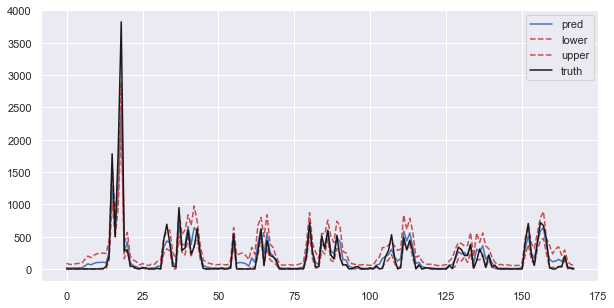

In [18]:
sns.set(rc={'figure.figsize':(10,5)})
index = np.arange(0,24*7)
plt.plot(range(len(index)),np.array(pred)[index],'b',label = "pred")
plt.plot(range(len(index)),np.array(lower)[index],"r--",label = "lower")
plt.plot(range(len(index)),np.array(upper)[index],"r--",label = "upper")
plt.plot(range(len(index)),np.array(truth)[index],'k',label = "truth")
plt.legend()
a = sum((np.array(truth)[index]>=np.array(lower)[index])*((np.array(truth)[index]<=np.array(upper)[index])))/len(index)
b = sum(abs(np.array(truth)[index]-np.array(pred)[index]))/sum(np.array(truth)[index])
c = sum(np.array(truth)[index]-np.array(pred)[index])/sum(np.array(truth)[index])
print(a,b,c)

0.8273809523809523 0.34794944544751094 0.14215054089729778


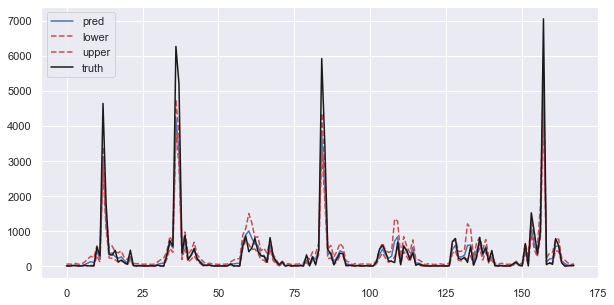

In [19]:
index = np.arange(24*7,24*14)
plt.plot(range(len(index)),np.array(pred)[index],'b',label = "pred")
plt.plot(range(len(index)),np.array(lower)[index],"r--",label = "lower")
plt.plot(range(len(index)),np.array(upper)[index],"r--",label = "upper")
plt.plot(range(len(index)),np.array(truth)[index],'k',label = "truth")
plt.legend()
a = sum((np.array(truth)[index]>=np.array(lower)[index])*((np.array(truth)[index]<=np.array(upper)[index])))/len(index)
b = sum(abs(np.array(truth)[index]-np.array(pred)[index]))/sum(np.array(truth)[index])
c = sum(np.array(truth)[index]-np.array(pred)[index])/sum(np.array(truth)[index])
print(a,b,c)

0.8333333333333334 0.31950701388125846 0.10894407207999121


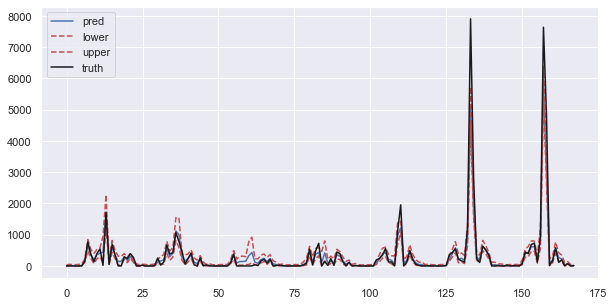

In [20]:
index = np.arange(24*14,24*21)
plt.plot(range(len(index)),np.array(pred)[index],'b',label = "pred")
plt.plot(range(len(index)),np.array(lower)[index],"r--",label = "lower")
plt.plot(range(len(index)),np.array(upper)[index],"r--",label = "upper")
plt.plot(range(len(index)),np.array(truth)[index],'k',label = "truth")
plt.legend()
a = sum((np.array(truth)[index]>=np.array(lower)[index])*((np.array(truth)[index]<=np.array(upper)[index])))/len(index)
b = sum(abs(np.array(truth)[index]-np.array(pred)[index]))/sum(np.array(truth)[index])
c = sum(np.array(truth)[index]-np.array(pred)[index])/sum(np.array(truth)[index])
print(a,b,c)

0.7321428571428571 0.42800506317021325 -0.0020778104177115427


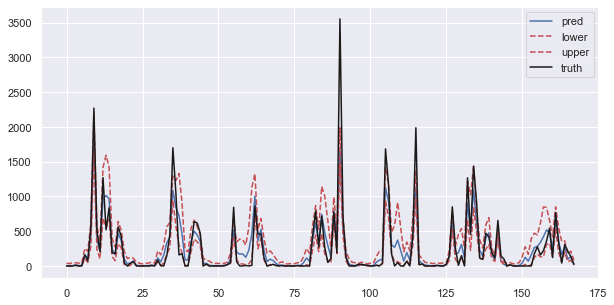

In [21]:
index = np.arange(24*21,24*28)
plt.plot(range(len(index)),np.array(pred)[index],'b',label = "pred")
plt.plot(range(len(index)),np.array(lower)[index],"r--",label = "lower")
plt.plot(range(len(index)),np.array(upper)[index],"r--",label = "upper")
plt.plot(range(len(index)),np.array(truth)[index],'k',label = "truth")
plt.legend()
a = sum((np.array(truth)[index]>=np.array(lower)[index])*((np.array(truth)[index]<=np.array(upper)[index])))/len(index)
b = sum(abs(np.array(truth)[index]-np.array(pred)[index]))/sum(np.array(truth)[index])
c = sum(np.array(truth)[index]-np.array(pred)[index])/sum(np.array(truth)[index])
print(a,b,c)

0.8630952380952381 0.29290532100924305 0.022233325006245315


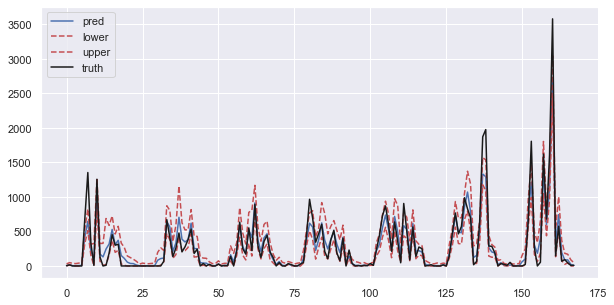

In [22]:
index = np.arange(24*28,24*35)
plt.plot(range(len(index)),np.array(pred)[index],'b',label = "pred")
plt.plot(range(len(index)),np.array(lower)[index],"r--",label = "lower")
plt.plot(range(len(index)),np.array(upper)[index],"r--",label = "upper")
plt.plot(range(len(index)),np.array(truth)[index],'k',label = "truth")
plt.legend()
a = sum((np.array(truth)[index]>=np.array(lower)[index])*((np.array(truth)[index]<=np.array(upper)[index])))/len(index)
b = sum(abs(np.array(truth)[index]-np.array(pred)[index]))/sum(np.array(truth)[index])
c = sum(np.array(truth)[index]-np.array(pred)[index])/sum(np.array(truth)[index])
print(a,b,c)

0.8571428571428571 0.3877650290423188 -0.06375003576640247


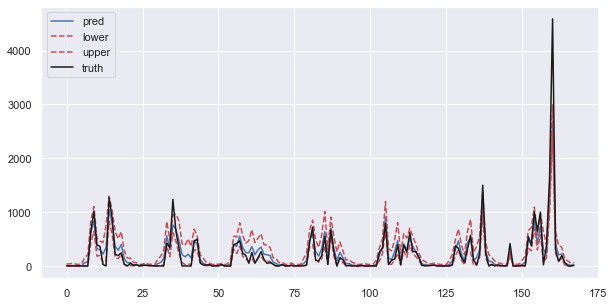

In [23]:
index = np.arange(24*35,24*42)
plt.plot(range(len(index)),np.array(pred)[index],'b',label = "pred")
plt.plot(range(len(index)),np.array(lower)[index],"r--",label = "lower")
plt.plot(range(len(index)),np.array(upper)[index],"r--",label = "upper")
plt.plot(range(len(index)),np.array(truth)[index],'k',label = "truth")
plt.legend()
a = sum((np.array(truth)[index]>=np.array(lower)[index])*((np.array(truth)[index]<=np.array(upper)[index])))/len(index)
b = sum(abs(np.array(truth)[index]-np.array(pred)[index]))/sum(np.array(truth)[index])
c = sum(np.array(truth)[index]-np.array(pred)[index])/sum(np.array(truth)[index])
print(a,b,c)

In [24]:
count = 0
for i in range(len(daily_truth)):
  if daily_truth[i]>=daily_ci_lower[i] and daily_truth[i]<=daily_ci_upper[i]:
    count = count + 1
count/42

0.38095238095238093